<a href="https://colab.research.google.com/github/Pranv45/Learning-Pytorch-/blob/main/Pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0+cu126'

### Data preparing and loading
- We will create a linear regression formula to make a straight line

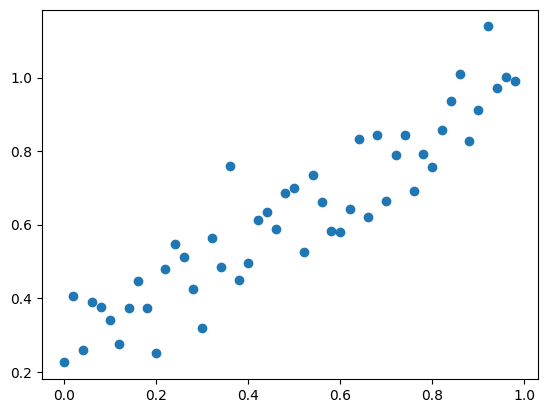

In [16]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start,end, step).unsqueeze(dim = 1)
y = weight*X + bias

# Add Gaussian noise with specified mean and variance
mean = 0
variance = 0.01  # You can adjust the variance as needed
noise = torch.randn(y.shape) * torch.sqrt(torch.tensor(variance)) + mean

y += noise
plt.scatter(X, y)
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [37]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=10, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="r", s=10, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="y", s=10, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})
  plt.show()

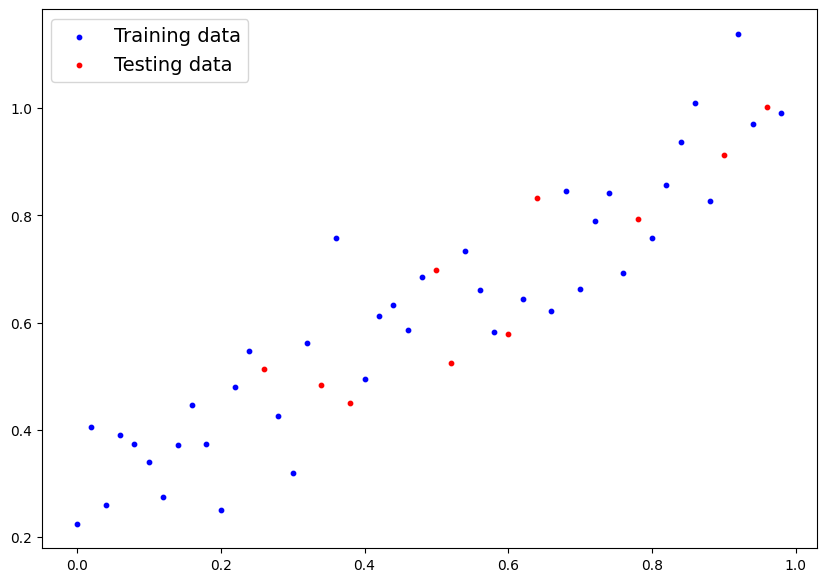

In [38]:
plot_predictions()

### Build model

In [39]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad= True,
                                                dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad= True,
                                             dtype = torch.float))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights*x + self.bias


In [40]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [41]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [42]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.2163],
        [0.3914],
        [0.3308],
        [0.4318],
        [0.2433],
        [0.4520],
        [0.3039],
        [0.2972],
        [0.3443],
        [0.2568]])


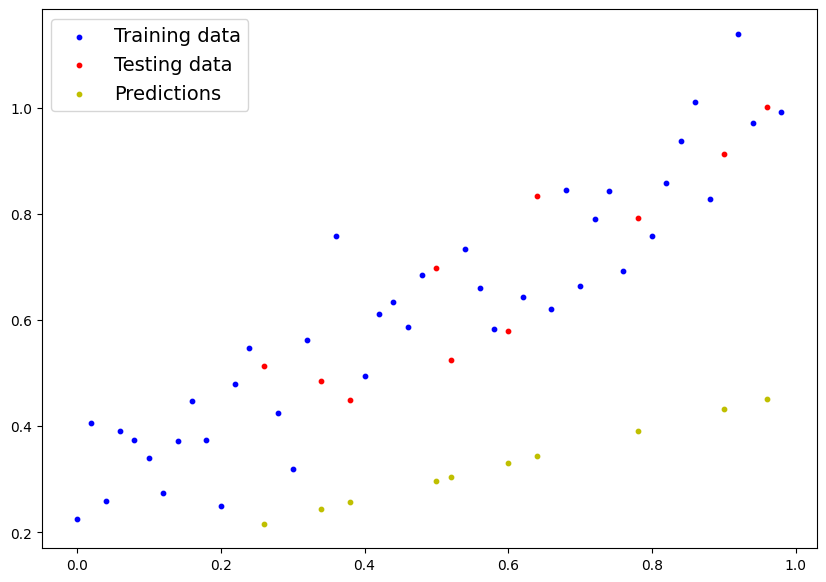

In [43]:
plot_predictions(predictions=y_preds)

### Train model

In [44]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [48]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.32407400012016296 | MAE Test Loss: 0.3394624590873718 
Epoch: 10 | MAE Train Loss: 0.20990073680877686 | MAE Test Loss: 0.2177084982395172 
Epoch: 20 | MAE Train Loss: 0.13273440301418304 | MAE Test Loss: 0.1233447790145874 
Epoch: 30 | MAE Train Loss: 0.09920334070920944 | MAE Test Loss: 0.09925370663404465 
Epoch: 40 | MAE Train Loss: 0.09080950915813446 | MAE Test Loss: 0.09107992798089981 
Epoch: 50 | MAE Train Loss: 0.0885683223605156 | MAE Test Loss: 0.0878373235464096 
Epoch: 60 | MAE Train Loss: 0.08686180412769318 | MAE Test Loss: 0.08564549684524536 
Epoch: 70 | MAE Train Loss: 0.08516539633274078 | MAE Test Loss: 0.08332947641611099 
Epoch: 80 | MAE Train Loss: 0.08380436897277832 | MAE Test Loss: 0.08156445622444153 
Epoch: 90 | MAE Train Loss: 0.08308915793895721 | MAE Test Loss: 0.08060566335916519 


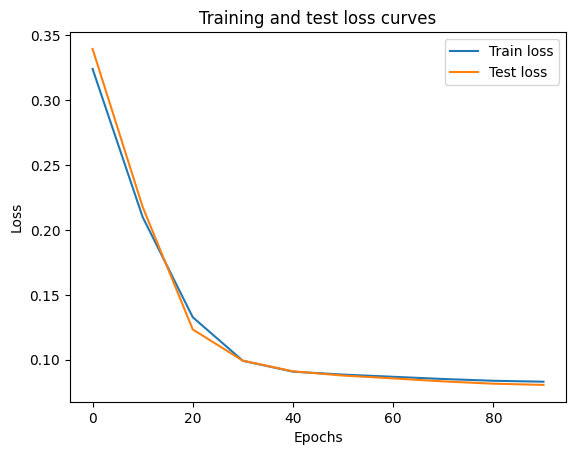

In [49]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [50]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.5478]), 'bias': tensor([0.3573])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### Making predictions with a trained PyTorch model (inference)

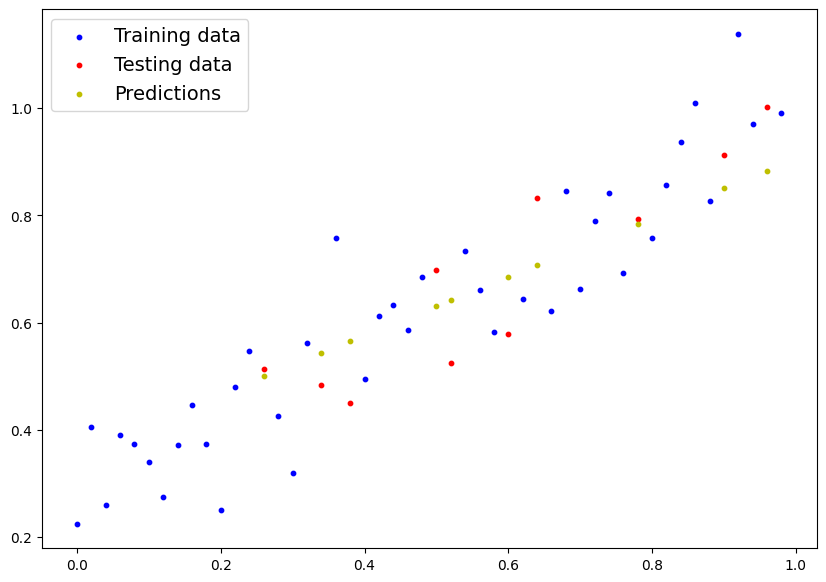

In [58]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
plot_predictions(predictions=y_pred.detach().numpy())

### Saving and loading a PyTorch model
- Saving a PyTorch model's state_dict()

In [59]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


- Loading a saved PyTorch model's state_dict()

In [60]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [61]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [62]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])